In [1]:

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256 # pixel size
CHANNELS = 3 # RGB
EPOCHS = 30

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 2 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0]


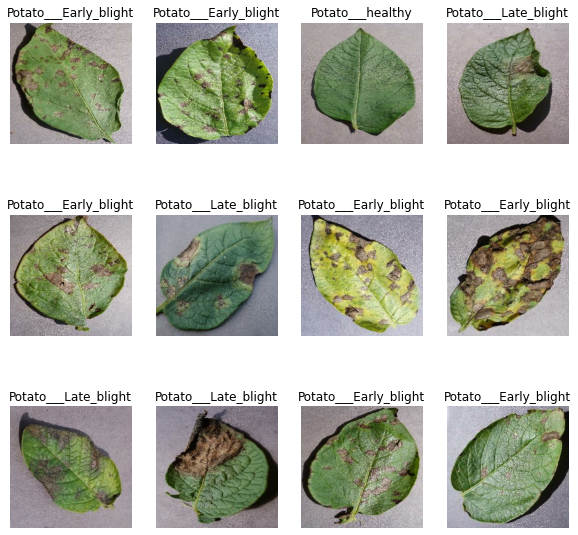

In [5]:
plt.figure(figsize=(10,10)) # to show image in bigger size
for image_batch, labels_batch in dataset.take(1): # from dataset.take(1) give output for 32 size batch/ and 256 is piyel size and 3 means color channel.
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12): # to show 12 image
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # convert tensor into numpy
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
#  USE 80% for  ==> Training
#  Use 20% ==> Test
       #  USE  10% ==> validation
       #  USE   10% ==> Test

In [7]:
train_size = 0.8 # Training size 80%
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54) # take first 54 batch means 54*32 image
len(train_ds)

54

In [9]:
test_ds= dataset.skip(54) # take batch before 54
len(test_ds)

14

In [10]:
val_size=0.1   # Take 10% for validation
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
# we make this function because by calling this function we get all above function
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split) == 1 # if anyone give another value
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size) # Because we get 54.40 value above so we convert it into integer   
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds) # ds means deta set

8

In [18]:
# from casche function take picture in memory so we can save time because not take photo from disc.
# we use shuffle because it give better result
# prefech for performance tuning
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
for image_batch, labels_batch in dataset.take(1): # from dataset.take(1) give output for 32 size batch/ and 256 is piyel size and 3 means color channel.
    print(image_batch[0].numpy()/255)

[[[0.5686275  0.5568628  0.6313726 ]
  [0.5803922  0.5686275  0.6431373 ]
  [0.5921569  0.5803922  0.654902  ]
  ...
  [0.63529414 0.6392157  0.70980394]
  [0.63529414 0.6392157  0.70980394]
  [0.6392157  0.6431373  0.7137255 ]]

 [[0.5686275  0.5568628  0.6313726 ]
  [0.57254905 0.56078434 0.63529414]
  [0.5803922  0.5686275  0.6431373 ]
  ...
  [0.6392157  0.6431373  0.7137255 ]
  [0.6431373  0.64705884 0.7176471 ]
  [0.6431373  0.64705884 0.7176471 ]]

 [[0.58431375 0.57254905 0.64705884]
  [0.5764706  0.5647059  0.6392157 ]
  [0.57254905 0.56078434 0.63529414]
  ...
  [0.6509804  0.654902   0.7254902 ]
  [0.64705884 0.6509804  0.72156864]
  [0.64705884 0.6509804  0.72156864]]

 ...

 [[0.34509805 0.33333334 0.41568628]
  [0.37254903 0.36078432 0.44313726]
  [0.34509805 0.33333334 0.41568628]
  ...
  [0.5019608  0.49019608 0.5647059 ]
  [0.47843137 0.46666667 0.5411765 ]
  [0.4509804  0.4392157  0.5137255 ]]

 [[0.30980393 0.29803923 0.38039216]
  [0.34901962 0.3372549  0.41960785]


In [20]:
# we use Keras for normalize picture
# if image is not 255*255 so first resize it

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
]
)

In [21]:
# we use data Augmentation if image is flip or vertical or horizontal

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
]
)


In [22]:
# Start making model with CNN(Convolution Nural Network)
# Here 32, 64 is filter
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3 # Because potato is healthy, late blight, early blight
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
    
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
# Now compile model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data= val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/30
54/54 [==============================] - 128s 2s/step - loss: 0.8984 - accuracy: 0.4948 - val_loss: 0.8633 - val_accuracy: 0.4844
Epoch 2/30
54/54 [==============================] - 124s 2s/step - loss: 0.6987 - accuracy: 0.6586 - val_loss: 0.5044 - val_accuracy: 0.7969
Epoch 3/30
54/54 [==============================] - 121s 2s/step - loss: 0.4727 - accuracy: 0.8027 - val_loss: 0.2635 - val_accuracy: 0.9062
Epoch 4/30
54/54 [==============================] - 123s 2s/step - loss: 0.3006 - accuracy: 0.8843 - val_loss: 0.1924 - val_accuracy: 0.9271
Epoch 5/30
54/54 [==============================] - 121s 2s/step - loss: 0.2351 - accuracy: 0.9074 - val_loss: 0.3898 - val_accuracy: 0.8542
Epoch 6/30
54/54 [==============================] - 126s 2s/step - loss: 0.2292 - accuracy: 0.9005 - val_loss: 0.3156 - val_accuracy: 0.8698
Epoch 7/30
54/54 [==============================] - 119s 2s/step - loss: 0.1480 - accuracy: 0.9381 - val_loss: 0.1919 - val_accuracy: 0.9271
Epoch 8/30
54

In [26]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 570ms/step - loss: 0.2046 - accuracy: 0.9258


In [27]:
scores

[0.2045821249485016, 0.92578125]

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
len(history.history['loss'])

30

In [33]:
history.history['accuracy']

[0.4947916567325592,
 0.6585648059844971,
 0.8026620149612427,
 0.8842592835426331,
 0.9074074029922485,
 0.9004629850387573,
 0.9380787014961243,
 0.953125,
 0.9334490895271301,
 0.9699074029922485,
 0.9670138955116272,
 0.9820601940155029,
 0.9774305820465088,
 0.9646990895271301,
 0.9872685074806213,
 0.984375,
 0.9849537014961243,
 0.9774305820465088,
 0.9739583134651184,
 0.9571759104728699,
 0.9872685074806213,
 0.9756944179534912,
 0.9774305820465088,
 0.9623842835426331,
 0.9878472089767456,
 0.9849537014961243,
 0.9780092835426331,
 0.9866898059844971,
 0.9942129850387573,
 0.9866898059844971]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

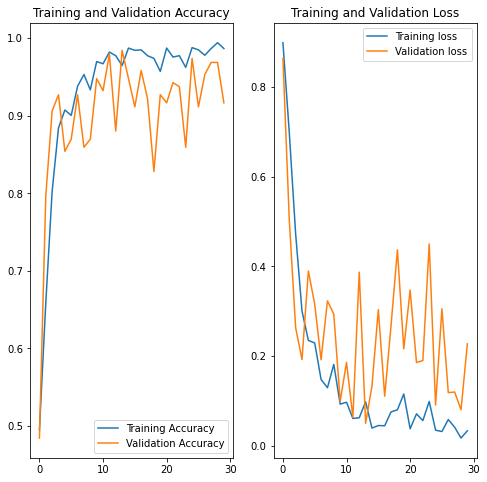

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label= 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label= 'Training loss')
plt.plot(range(EPOCHS), val_loss, label= 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual Label: Potato___Late_blight
predicted Label: Potato___Late_blight


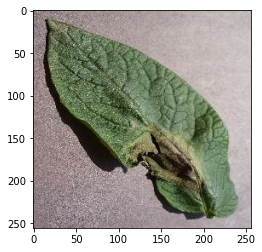

In [52]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("uint8")
    
    print("First image to predict")
    
    plt.imshow(first_image)
    
    print("Actual Label:", class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print("predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

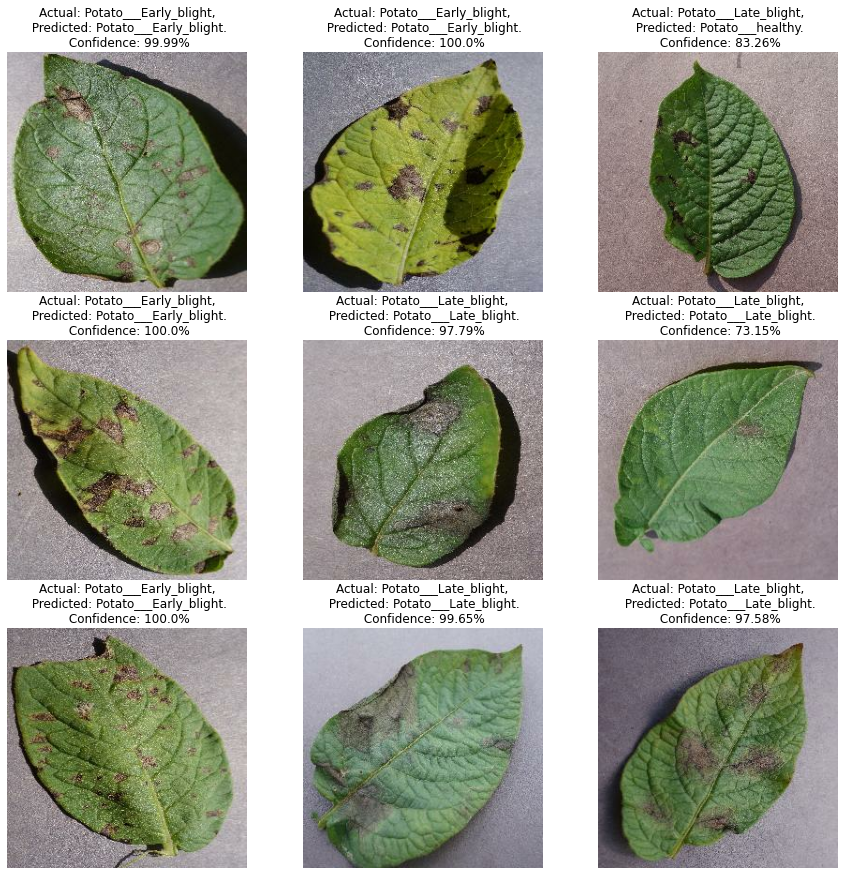

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class , confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [71]:
model_version = 1
model.save(f"../models/{model_version}")

KeyError: "Failed to add concrete function 'b'__inference_sequential_2_layer_call_fn_25761'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."